
# APM466 2020 Assignment #1: Yield Curves Empirical Questions

### Load data

In [1]:
%pylab
%matplotlib inline
import pandas as pd
from google.colab import files
uploaded = files.upload()
#from IPython.display import display
#pd.set_option('display.max_columns', None)
#pd.reset_option("all")

Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


Saving selected_bonds.csv to selected_bonds.csv
Saving selected_close.csv to selected_close.csv


In [2]:
import io
bonds = pd.read_csv(io.BytesIO(uploaded['selected_bonds.csv']), parse_dates=['Maturity Date', 'Issue Date'])
print(bonds)

            Name          ISIN  Coupon Issue Date Maturity Date
0       CDA 2021  CA135087F585  0.0075 2016-04-11    2021-09-01
1       CDA 2022  CA135087ZU15  0.0275 2011-08-02    2022-06-01
2       CDA 2021  CA135087F254  0.0075 2015-10-19    2021-03-01
3       CDA 2020  CA135087D929  0.0150 2014-10-14    2020-03-01
4       CDA 2020  CA135087E596  0.0075 2015-04-13    2020-09-01
5       CDA 2022  CA135087G328  0.0050 2016-10-11    2022-03-01
6       CDA 2024  CA135087J546  0.0225 2018-10-05    2024-03-01
7      CDA 19/24  CA135087J967  0.0150 2019-04-05    2024-09-01
8   CANADA 19/25  CA135087K528  0.0125 2019-10-11    2025-03-01
9       CDA 2023  CA135087H490  0.0175 2017-10-06    2023-03-01
10      CDA 2023  CA135087A610  0.0150 2012-07-30    2023-06-01


In [3]:
close = pd.read_csv(io.BytesIO(uploaded['selected_close.csv']), parse_dates=['Date'])
print(close)

        Date  CDA 2021  CDA 2022  ...  CANADA 19/25  CDA 2023  CDA 2023.1
0 2020-01-15     98.42    102.51  ...         98.47    100.38       99.56
1 2020-01-14     98.41    102.47  ...         98.34    100.31       99.49
2 2020-01-13     98.38    102.46  ...         98.24    100.27       99.44
3 2020-01-10     98.43    102.52  ...         98.25    100.31       99.53
4 2020-01-09     98.43    102.52  ...         98.30    100.35       99.54
5 2020-01-08     98.46    102.58  ...         98.48    100.44       99.62
6 2020-01-07     98.46    102.59  ...         98.48    100.45       99.61
7 2020-01-06     98.49    102.62  ...         98.58    100.48       99.65
8 2020-01-03     98.45    102.59  ...         98.43    100.42       99.59
9 2020-01-02     98.41    102.53  ...         98.24    100.31       99.48

[10 rows x 12 columns]


### Construct 5-year Yield Curve
First we construct a 5-year yield curve corresponding to data on Jan 15 only. 
Obtain a list of raw Time to Maturity and raw Yield to Maturity (not interpolated) respectively:


$$TTM = \frac{(Maturity - Today)}{365}$$
$$Coupon = Par \times AnnualCoupon Rate \div 2$$
$$Dirty Price = Accrued Interest + Clean Price \approx (0.5 - TTM \bmod 0.5) \times AnnualCoupon Rate + CleanPrice$$
<br>
Solve the following equation for $YTM$ using the Newton-Raphson method: 
<br><br>
$$Dirty Price = Par \cdot e^{-TTM \cdot YTM} + Coupon \cdot e^{-TTM \cdot YTM} + Coupon \cdot e^{-(TTM - 0.5) \cdot YTM} + Coupon \cdot e^{-(TTM - 1) \cdot YTM} + \cdots + Coupon \cdot e^{-(TTM \bmod 0.5) \cdot YTM}$$

Note that the above is based on the assumptions below:


*   The Government of Canada pays coupons semi-annually.
*   We adopt instantaneous compounding:
$$P_{\infty} = 	\lim_{n\to\infty} P_{n} = \lim_{n\to\infty} \sum_{i} p_i (1 + \frac{YTM}{n})^{-t_{i}n} = \sum_{i} p_i e^{-YTMt_{i}}$$

            Name          ISIN  Coupon Issue Date Maturity Date       ttm
3       CDA 2020  CA135087D929  0.0150 2014-10-14    2020-03-01  0.126027
4       CDA 2020  CA135087E596  0.0075 2015-04-13    2020-09-01  0.630137
2       CDA 2021  CA135087F254  0.0075 2015-10-19    2021-03-01  1.126027
0       CDA 2021  CA135087F585  0.0075 2016-04-11    2021-09-01  1.630137
5       CDA 2022  CA135087G328  0.0050 2016-10-11    2022-03-01  2.126027
1       CDA 2022  CA135087ZU15  0.0275 2011-08-02    2022-06-01  2.378082
9       CDA 2023  CA135087H490  0.0175 2017-10-06    2023-03-01  3.126027
10      CDA 2023  CA135087A610  0.0150 2012-07-30    2023-06-01  3.378082
6       CDA 2024  CA135087J546  0.0225 2018-10-05    2024-03-01  4.128767
7      CDA 19/24  CA135087J967  0.0150 2019-04-05    2024-09-01  4.632877
8   CANADA 19/25  CA135087K528  0.0125 2019-10-11    2025-03-01  5.128767
Bond 3: 0.06995957219596474
Bond 4: 0.02302959679711336
Bond 2: 0.019560969479184617
Bond 0: 0.01901661550709153

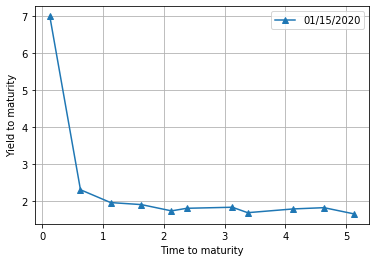

(<matplotlib.legend.Legend at 0x7f88c61f7f28>, None)

In [4]:
import datetime
tr, yr = [], []
today = datetime.datetime(2020, 1, 15)
bonds['ttm'] = [(maturity - today).days / 365 for maturity in bonds['Maturity Date']]
bonds = bonds.sort_values(by=['ttm'])
print(bonds)

from scipy import optimize
import numpy as np

for i, bond in bonds.iterrows():
    par = 100
    ttm = bond['ttm']
    coupon = par * bond['Coupon'] / 2. # semi-annual coupon payment
    price = (0.5 - ttm % 0.5) * bond['Coupon'] + close.iloc[close.loc[close['Date'] == today].index[0], i+1]
    def RHS(ytm): #, ttm, coupon, par, PRICE
      if ttm <= (ttm % 0.5): # zero-coupon bond maturing soon
        return (coupon + par) * np.exp(- ttm * ytm) - price
      else: #non-zero-coupon bonds
        temp = 0
        for j in np.arange(ttm, 0, -0.5):
          temp += coupon * np.exp(- j * ytm)
        return temp + par * np.exp(- ttm * ytm) - price
    ytm = optimize.newton(RHS, 0.01)
    print('Bond ' + str(i) + ': ' + str(ytm))
    tr.append(ttm)
    yr.append(ytm)

bonds['ytm'] = yr
print(bonds)
xlabel('Time to maturity'), ylabel('Yield to maturity'), grid(True)
plot(tr, array(yr)*100, marker='^', label=today.strftime("%m/%d/%Y"))
legend(loc='upper right'), show()


#### Interpolate
Construct a densely interpolated set using a B-spline of degree 3 for relatively smooth plotting.




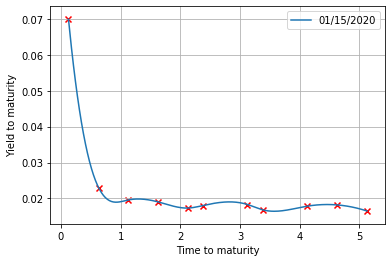

In [5]:
from scipy.interpolate import make_interp_spline, BSpline
import scipy as sp
ts = np.linspace(min(tr), max(tr), 300)
spl = make_interp_spline(tr, yr, k=3)
ys = spl(ts)

xlabel('Time to maturity'), ylabel('Yield to maturity'), grid(True)
plt.plot(ts, ys, label=today.strftime("%m/%d/%Y"))
plt.scatter(tr, yr, marker='x', color='red')
legend(loc='upper right')
plt.show()

#### Superimposed Yield Curve
Now we finish Question 4(a) by superimposing 10 yield curves corresponding to each day of data (Jan 2 to
Jan 15).
To avoid the disproportionate display caused by bonds with maturity less than 1 year, we may zoom in only to plot the 1-5 years yield curve.

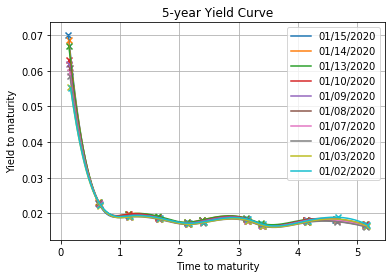

In [7]:
import datetime
from scipy import optimize
import numpy as np
from scipy.interpolate import make_interp_spline, BSpline
import scipy as sp

for today in close['Date']:
  tr, yr = [], []
  #today = datetime.datetime(2020, 1, 15)
  bonds['ttm'] = [(maturity - today).days / 365 for maturity in bonds['Maturity Date']]
  bonds = bonds.sort_values(by=['ttm'])
  #print(bonds)


  for i, bond in bonds.iterrows():
      par = 100
      ttm = bond['ttm']
      coupon = par * bond['Coupon'] / 2. # semi-annual coupon payment
      price = (0.5 - ttm % 0.5) * bond['Coupon'] + close.iloc[close.loc[close['Date'] == today].index[0], i+1]
      def RHS(ytm): #, ttm, coupon, par, PRICE
        if ttm <= (ttm % 0.5): # zero-coupon bond maturing soon
          return (coupon + par) * np.exp(- ttm * ytm) - price
        else: #non-zero-coupon bonds
          temp = 0
          for j in np.arange(ttm, 0, -0.5):
            temp += coupon * np.exp(- j * ytm)
          return temp + par * np.exp(- ttm * ytm) - price
      ytm = optimize.newton(RHS, 0.01)
      #print('Bond ' + str(i) + ': ' + str(ytm))
      tr.append(ttm)
      yr.append(ytm)


  ts = np.linspace(min(tr), max(tr), 300)
  spl = make_interp_spline(tr, yr, k=3)
  ys = spl(ts)

  xlabel('Time to maturity'), ylabel('Yield to maturity'), grid(True)
  plt.plot(ts, ys, label=today.strftime("%m/%d/%Y"))
  legend(loc='upper right')
  plt.scatter(tr, yr, marker='x')
plt.title('5-year Yield Curve')
plt.savefig("yieldcurve.png")
files.download("yieldcurve.png") 
plt.show()


### Construct Spot Rate Treasury Curve

The bootstrapping method is built on the following:


*   For $0 < t_{1} < \frac{1}{2}$
$$P(0, t_{1}) = (Coupon + Par) \cdot e^{-r(t_{1}) \cdot t_{1}}$$
*   For $0 < t_{1} < \frac{1}{2} < t_{2} < 1$
$$P(0, t_{2}) = Coupon \cdot e^{-r(t_{1}) \cdot t_{1}} + (Coupon + Par) \cdot e^{-r(t_{2}) \cdot t_{2}}$$
*   For $0 < t_{1} < \frac{1}{2} < t_{2} < 1 < t_{3} < \frac{3}{2}$
$$P(0, t_{2}) = Coupon \cdot e^{-r(t_{1}) \cdot t_{1}} + Coupon \cdot e^{-r(t_{2}) \cdot t_{2}} + (Coupon + Par) \cdot e^{-r(t_{3}) \cdot t_{3}}$$
*   $\cdots$
*   For all $t_{i} \in \{TTM, TTM-0.5, TTM-1, ..., TTM \bmod 0.5\}$ 

Hence the pseudo code is

    Create an empty list storing time to maturity;
    Create an empty list storing calculated spot rates;
    for each bond:
      Get its timeToMaturity from the current date;
      Calculate its semi-annual coupon;
      Calculate its dirtyPrice;
      
      # Bootstrap
      couponSum = 0;
      if ttm > (ttm % 0.5): #non-zero-coupon bonds
        for j in TTM-0.5, TTM-1, ..., TTM mod 0.5:
          couponSum += discounted coupons by the spot rate on day j;
      spot = - log((dirtyPrice - couponSum) / (coupon + par)) / timeToMaturity;
      
      Store current timeToMaturity into list;
      Store current spot rate into list;
    Plot the spot rate curve with interpolation.
Repeat the above procedure for data of each day and then superimpose the plots.

Bond 3: 0.06995957219596374
Bond 4: 0.02299308004760836
Bond 2: 0.019532357039048463
Bond 0: 0.01899384041961467
Bond 5: 0.01729553906415133
Bond 1: 0.017851650183236475
Bond 9: 0.018273920157580524
Bond 10: 0.01674122193127622
Bond 6: 0.01781335096308806
Bond 7: 0.018176222871933805
Bond 8: 0.016437899191539113


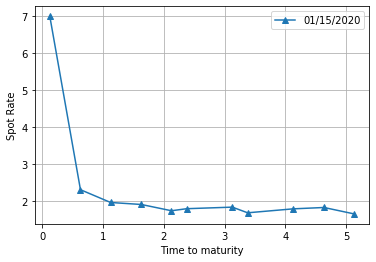

(<matplotlib.legend.Legend at 0x7f88c1610588>, None)

In [8]:
# Implementation on a single day (Jan 15 2020)
import datetime
import numpy as np
from scipy.interpolate import make_interp_spline, BSpline
import scipy as sp


tr, rr = [], []
today = datetime.datetime(2020, 1, 15)
bonds['ttm'] = [(maturity - today).days / 365 for maturity in bonds['Maturity Date']]
bonds = bonds.sort_values(by=['ttm'])
#print(bonds)


for i, bond in bonds.iterrows():
    par = 100
    ttm = bond['ttm']
    coupon = par * bond['Coupon'] / 2. # semi-annual coupon payment
    price = (0.5 - ttm % 0.5) * bond['Coupon'] + close.iloc[close.loc[close['Date'] == today].index[0], i+1]
    
    # Bootstrap
    couponSum = 0

    if ttm > (ttm % 0.5): #non-zero-coupon bonds
      for j in np.arange(ttm - 0.5, 0, -0.5):
        couponSum += coupon * np.exp(- rr[int(j//0.5)] * j)
    
    spot = - np.log((price - couponSum) / (coupon + par)) / ttm
    print('Bond ' + str(i) + ': ' + str(spot))
    tr.append(ttm)
    rr.append(spot)

xlabel('Time to maturity'), ylabel('Spot Rate'), grid(True)
plot(tr, array(rr)*100, marker='^', label=today.strftime("%m/%d/%Y"))
legend(loc='upper right'), show()


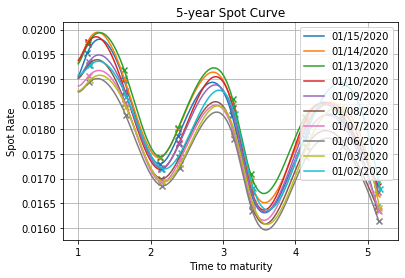

In [12]:
# Superimpose Spot Curves
import datetime
import numpy as np
from scipy.interpolate import make_interp_spline, BSpline
import scipy as sp

for today in close['Date']:
  tr, rr = [], []
  #today = datetime.datetime(2020, 1, 15)
  bonds['ttm'] = [(maturity - today).days / 365 for maturity in bonds['Maturity Date']]
  bonds = bonds.sort_values(by=['ttm'])
  #print(bonds)


  for i, bond in bonds.iterrows():
      par = 100
      ttm = bond['ttm']
      coupon = par * bond['Coupon'] / 2. # semi-annual coupon payment
      price = (0.5 - ttm % 0.5) * bond['Coupon'] + close.iloc[close.loc[close['Date'] == today].index[0], i+1]
      
      # Bootstrap
      couponSum = 0

      if ttm > (ttm % 0.5): #non-zero-coupon bonds
        for j in np.arange(ttm - 0.5, 0, -0.5):
          couponSum += coupon * np.exp(- rr[int(j//0.5)] * j)
    
      spot = - np.log((price - couponSum) / (coupon + par)) / ttm
      #print('Bond ' + str(i) + ': ' + str(spot))
      tr.append(ttm)
      rr.append(spot)


  ts = np.linspace(1, max(tr), 300)
  spl = make_interp_spline(tr, rr, k=3)
  rs = spl(ts)

  xlabel('Time to maturity'), ylabel('Spot Rate'), grid(True)
  plt.plot(ts, rs, label=today.strftime("%m/%d/%Y"))
  legend(loc='upper right')
  plt.scatter(np.delete(tr, [0,1]), np.delete(rr, [0,1]), marker='x')
plt.title('5-year Spot Curve')
plt.savefig("spotcurve.png")
files.download("spotcurve.png") 
plt.show()


### Construct Forward Rate Treasury Curve

Forward rates are calculated from spot rates.

$$Forward Rate= \frac{(1+r_{2})^{t_{2}}}{(1+r_{1})^{t_{1}}} − 1$$
where:<br>
$r_{2} = $ The spot rate for the bond of term $t_{2}$ periods
<br>
$r_{1} = $ The spot rate for the bond of term $t_{1}$ periods with $t_{1} < t_{2}$

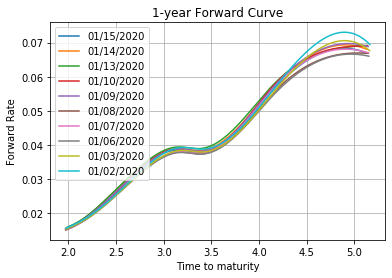

In [11]:
# Superimpose Forward Curves
import datetime
import numpy as np
from scipy.interpolate import make_interp_spline, BSpline
import scipy as sp

for today in close['Date']:
  tr, rr = [], []
  #today = datetime.datetime(2020, 1, 15)
  bonds['ttm'] = [(maturity - today).days / 365 for maturity in bonds['Maturity Date']]
  bonds = bonds.sort_values(by=['ttm'])
  #print(bonds)


  for i, bond in bonds.iterrows():
      par = 100
      ttm = bond['ttm']
      coupon = par * bond['Coupon'] / 2. # semi-annual coupon payment
      price = (0.5 - ttm % 0.5) * bond['Coupon'] + close.iloc[close.loc[close['Date'] == today].index[0], i+1]
      
      # Bootstrap
      couponSum = 0

      if ttm > (ttm % 0.5): #non-zero-coupon bonds
        for j in np.arange(ttm - 0.5, 0, -0.5):
          couponSum += coupon * np.exp(- rr[int(j//0.5)] * j)
    
      spot = - np.log((price - couponSum) / (coupon + par)) / ttm
      #print('Bond ' + str(i) + ': ' + str(spot))
      tr.append(ttm)
      rr.append(spot)


  ts = np.linspace(1, max(tr), 300)
  spl = make_interp_spline(tr, rr, k=3)
  rs = spl(ts)

  tfs, fs = [], []
  r1 = rs[0] # Construct 1-year forward curve
  t1 = 1
  for i in range(np.where(ts > 1.97)[0][0], 300): # Term ranges from 2 to 5 years
    temp = (1+rs[i])**ts[i] / (1+r1)**t1 - 1
    tfs.append(ts[i])
    fs.append(temp)

  xlabel('Time to maturity'), ylabel('Forward Rate'), grid(True)
  plt.plot(tfs, fs, label=today.strftime("%m/%d/%Y"))
  legend(loc='upper left')
plt.title('1-year Forward Curve')
plt.savefig("forwardcurve.png")
files.download("forwardcurve.png") 
plt.show()


### Time Series and Covariance Matrices

In [19]:
# First, we obtain the time series of i-year yield for i = 1, . . . , 5.
import datetime
from scipy import optimize
import numpy as np
from scipy.interpolate import make_interp_spline, BSpline
import scipy as sp

list_2d = []

for today in close['Date']:
  tr, yr = [], []
  #today = datetime.datetime(2020, 1, 15)
  bonds['ttm'] = [(maturity - today).days / 365 for maturity in bonds['Maturity Date']]
  bonds = bonds.sort_values(by=['ttm'])
  #print(bonds)


  for i, bond in bonds.iterrows():
      par = 100
      ttm = bond['ttm']
      coupon = par * bond['Coupon'] / 2. # semi-annual coupon payment
      price = (0.5 - ttm % 0.5) * bond['Coupon'] + close.iloc[close.loc[close['Date'] == today].index[0], i+1]
      def RHS(ytm): #, ttm, coupon, par, PRICE
        if ttm <= (ttm % 0.5): # zero-coupon bond maturing soon
          return (coupon + par) * np.exp(- ttm * ytm) - price
        else: #non-zero-coupon bonds
          temp = 0
          for j in np.arange(ttm, 0, -0.5):
            temp += coupon * np.exp(- j * ytm)
          return temp + par * np.exp(- ttm * ytm) - price
      ytm = optimize.newton(RHS, 0.01)
      #print('Bond ' + str(i) + ': ' + str(ytm))
      tr.append(ttm)
      yr.append(ytm)


  ts = np.linspace(1, max(tr), 300)
  spl = make_interp_spline(tr, yr, k=3)
  ys = spl(ts)

  ya = []
  for i in [np.where(ts > 0.97)[0][0], np.where(ts > 1.97)[0][0], np.where(ts > 2.97)[0][0], np.where(ts > 3.97)[0][0], np.where(ts > 4.97)[0][0]]:
    ya.append(ys[i])
  list_2d.append(ya)

column_names = [str(i) + '-year yield' for i in [1, 2, 3, 4, 5]]
df_yield_raw = pd.DataFrame(list_2d, columns = column_names)
print(df_yield_raw)

   1-year yield  2-year yield  3-year yield  4-year yield  5-year yield
0      0.019081      0.017497      0.018863      0.017382      0.017225
1      0.019361      0.017592      0.019077      0.017558      0.017469
2      0.019338      0.017672      0.019179      0.017788      0.017396
3      0.019402      0.017386      0.019024      0.017630      0.017428
4      0.019051      0.017478      0.018855      0.017472      0.017496
5      0.019042      0.017272      0.018526      0.017153      0.016962
6      0.018891      0.017237      0.018484      0.017287      0.017177
7      0.018770      0.017144      0.018354      0.016914      0.016877
8      0.018798      0.017278      0.018490      0.017017      0.017544
9      0.019109      0.017538      0.018810      0.017287      0.018046


In [21]:
# Then we calculate the daily log-returns & the required covariance matrix
# Note that our original data has dates in reverse chronological order
df_yield = pd.DataFrame()
for i in [1, 2, 3, 4, 5]:
  df_yield[str(i) + '-year yield log'] = np.log(df_yield_raw[str(i) + '-year yield'].shift(1)) - np.log(df_yield_raw[str(i) + '-year yield'])

df_yield = df_yield.dropna(axis = 0)
print(df_yield)
print(df_yield.cov())
df_yield.cov().to_csv('yield_cov.csv') 
files.download('yield_cov.csv')

   1-year yield log  2-year yield log  ...  4-year yield log  5-year yield log
1         -0.014550         -0.005412  ...         -0.010061         -0.014109
2          0.001213         -0.004538  ...         -0.013055          0.004211
3         -0.003346          0.016343  ...          0.008947         -0.001833
4          0.018264         -0.005284  ...          0.008994         -0.003892
5          0.000501          0.011829  ...          0.018395          0.030983
6          0.007949          0.002026  ...         -0.007731         -0.012584
7          0.006410          0.005435  ...          0.021767          0.017596
8         -0.001466         -0.007812  ...         -0.006047         -0.038734
9         -0.016427         -0.014897  ...         -0.015739         -0.028221

[9 rows x 5 columns]
                  1-year yield log  ...  5-year yield log
1-year yield log          0.000117  ...          0.000086
2-year yield log          0.000029  ...          0.000149
3-year yield l

In [22]:
# Similarly for forward rates 1yr-1yr, 1yr-2yr, 1yr-3yr, 1yr-4yr.
import datetime
import numpy as np
from scipy.interpolate import make_interp_spline, BSpline
import scipy as sp

list_2d = []

for today in close['Date']:
  tr, rr = [], []
  #today = datetime.datetime(2020, 1, 15)
  bonds['ttm'] = [(maturity - today).days / 365 for maturity in bonds['Maturity Date']]
  bonds = bonds.sort_values(by=['ttm'])
  #print(bonds)


  for i, bond in bonds.iterrows():
      par = 100
      ttm = bond['ttm']
      coupon = par * bond['Coupon'] / 2. # semi-annual coupon payment
      price = (0.5 - ttm % 0.5) * bond['Coupon'] + close.iloc[close.loc[close['Date'] == today].index[0], i+1]
      
      # Bootstrap
      couponSum = 0

      if ttm > (ttm % 0.5): #non-zero-coupon bonds
        for j in np.arange(ttm - 0.5, 0, -0.5):
          couponSum += coupon * np.exp(- rr[int(j//0.5)] * j)
    
      spot = - np.log((price - couponSum) / (coupon + par)) / ttm
      #print('Bond ' + str(i) + ': ' + str(spot))
      tr.append(ttm)
      rr.append(spot)


  ts = np.linspace(1, max(tr), 300)
  spl = make_interp_spline(tr, rr, k=3)
  rs = spl(ts)

  tfs, fs = [], []
  r1 = rs[0] # Construct 1-year forward curve
  t1 = 1
  for i in range(np.where(ts > 1.97)[0][0], 300): # Term ranges from 2 to 5 years
    temp = (1+rs[i])**ts[i] / (1+r1)**t1 - 1
    tfs.append(ts[i])
    fs.append(temp)

  fa = []
  for i in [np.where(np.asarray(tfs) > 1.97)[0][0], np.where(np.asarray(tfs) > 2.97)[0][0], np.where(np.asarray(tfs) > 3.97)[0][0], np.where(np.asarray(tfs) > 4.97)[0][0]]:
    fa.append(fs[i])
  list_2d.append(fa)

column_names = ['1yr-' + str(i) + '-yr' for i in [1, 2, 3, 4]]
df_forward_raw = pd.DataFrame(list_2d, columns = column_names)
print(df_forward_raw)

   1yr-1-yr  1yr-2-yr  1yr-3-yr  1yr-4-yr
0  0.015634  0.037263  0.050796  0.068172
1  0.015553  0.037657  0.051016  0.069215
2  0.015746  0.038020  0.052049  0.068876
3  0.015145  0.037568  0.051466  0.068898
4  0.015446  0.037434  0.051203  0.069699
5  0.015062  0.036460  0.049921  0.066930
6  0.015154  0.036236  0.050443  0.068028
7  0.015101  0.035992  0.049034  0.066634
8  0.015369  0.036455  0.049539  0.070313
9  0.015580  0.037139  0.050362  0.072701


In [24]:
df_forward = pd.DataFrame()
for i in [1, 2, 3, 4]:
  df_forward['1yr-' + str(i) + '-yr log'] = np.log(df_forward_raw['1yr-' + str(i) + '-yr'].shift(1)) - np.log(df_forward_raw['1yr-' + str(i) + '-yr'])

df_forward = df_forward.dropna(axis = 0)
print(df_forward)
print(df_forward.cov())
df_forward.cov().to_csv('forward_cov.csv') 
files.download('forward_cov.csv')

   1yr-1-yr log  1yr-2-yr log  1yr-3-yr log  1yr-4-yr log
1      0.005223     -0.010526     -0.004324     -0.015185
2     -0.012342     -0.009597     -0.020045      0.004904
3      0.038905      0.011955      0.011257     -0.000314
4     -0.019657      0.003571      0.005131     -0.011560
5      0.025176      0.026372      0.025343      0.040542
6     -0.006125      0.006151     -0.010388     -0.016276
7      0.003530      0.006776      0.028316      0.020711
8     -0.017582     -0.012804     -0.010244     -0.053749
9     -0.013672     -0.018588     -0.016469     -0.033400
              1yr-1-yr log  1yr-2-yr log  1yr-3-yr log  1yr-4-yr log
1yr-1-yr log      0.000407      0.000198      0.000221      0.000337
1yr-2-yr log      0.000198      0.000206      0.000203      0.000314
1yr-3-yr log      0.000221      0.000203      0.000312      0.000356
1yr-4-yr log      0.000337      0.000314      0.000356      0.000784


### Principal Component Analysis

In [25]:
from numpy import linalg as LA
w, v = LA.eig(df_yield.cov())
print(w, v)
print('The first principal component of the yields is: ', v[np.argmax(w)])

[7.80935903e-04 1.20031478e-04 6.69116434e-05 4.71885040e-06
 3.41211168e-05] [[ 0.20581782  0.71944902 -0.54886962  0.33607808 -0.16070406]
 [ 0.28698507 -0.01237781  0.54539159  0.42425722 -0.66335524]
 [ 0.37279605  0.31050394  0.12220099 -0.8226138  -0.27015527]
 [ 0.44774813  0.30413064  0.46860641  0.1644921   0.67851053]
 [ 0.73199953 -0.5416011  -0.40836882  0.05749976  0.02781396]]
The first principal component of the yields is:  [ 0.20581782  0.71944902 -0.54886962  0.33607808 -0.16070406]


In [26]:
from numpy import linalg as LA
w, v = LA.eig(df_forward.cov())
print(w, v)
print('The first principal component of the forward rates is: ', v[np.argmax(w)])

[1.34009228e-03 2.11259225e-04 1.15034505e-04 4.21469355e-05] [[-0.43243633 -0.81741008  0.35924501  0.12562886]
 [-0.34892763 -0.06662737 -0.25735659 -0.89865337]
 [-0.41172688 -0.07917012 -0.81536571  0.39923905]
 [-0.72230832  0.56668655  0.37401786  0.13133043]]
The first principal component of the forward rates is:  [-0.43243633 -0.81741008  0.35924501  0.12562886]
